interactive(children=(Dropdown(description='Geounit:', options=('ABC', 'ACE', 'APG', 'ASG', 'AZT', 'BRZ', 'CAL…

Total Revenue Comparison Across All Geounits (from Oct 2022):
   Geounit  Tickets Revenue   RPE Revenue   Difference  Difference %
26     RUL     6.757109e+07  1.523117e+08  84740649.05    125.409621
1      ACE     4.465297e+07  1.235861e+08  78933177.89    176.770293
8      EAG     3.565406e+07  9.280553e+07  57151461.46    160.294382
13     GTC     5.754577e+07  1.066999e+08  49154100.84     85.417401
3      ASG     1.299176e+06  4.630000e+07  45000822.75   3463.796011
5      BRZ     4.412119e+07  8.679753e+07  42676346.22     96.725289
14     ING     5.196606e+07  8.485285e+07  32886789.94     63.285127
23     NAW     5.014650e+07  7.732286e+07  27176355.62     54.193919
19     KZU     1.910350e+07  4.514113e+07  26037637.95    136.297758
2      APG     3.893752e+07  5.742962e+07  18492096.36     47.491711
15     INM     2.937281e+07  4.751026e+07  18137451.92     61.749118
20     MCA     6.822864e+07  8.226257e+07  14033929.59     20.568972
4      AZT     8.069163e+06  2.199797e+07

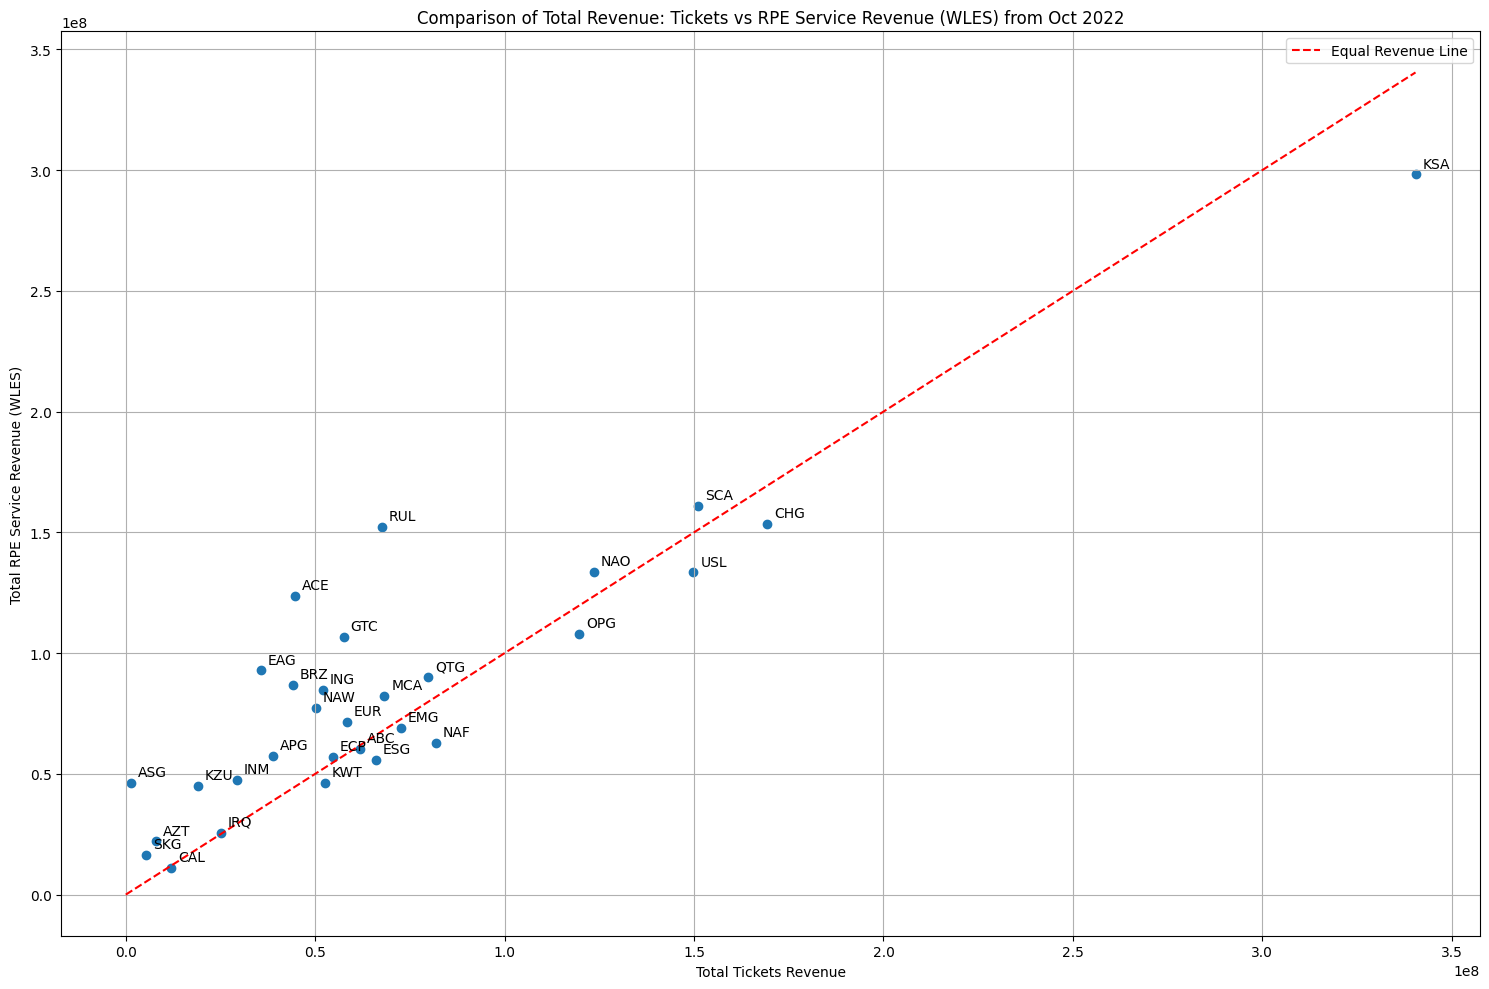


Overall Correlation between Tickets and RPE Service Revenue: 0.8124


In [5]:
# 03_compare_revenue_sources.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import ipywidgets as widgets
from ipywidgets import interact
import importlib
import utils.revenue_data_preprocessing as rdp

# Reload the module to ensure we have the latest version
importlib.reload(rdp)

# Load and preprocess the data
tickets_df = pd.read_csv('../raw_data/global_tickets_wles_ops_data.csv')
rpe_revenue_df = pd.read_csv('../raw_data/global_rpe_revenue.csv')

tickets_df = rdp.preprocess_tickets_data(tickets_df)
rpe_revenue_df = rdp.preprocess_rpe_data(rpe_revenue_df)  # This now includes only WLES data

# Prepare monthly revenue data for tickets
tickets_monthly = tickets_df.groupby(['Sl Geounit (Code)', pd.Grouper(key='Adjusted Date', freq='MS')])['Field Ticket USD net value'].sum().reset_index()
tickets_monthly.columns = ['Geounit', 'Date', 'Tickets Revenue']

# Prepare monthly revenue data for RPE (WLES only)
rpe_monthly = rpe_revenue_df.groupby(['SL Geounit (Code)', pd.Grouper(key='Month Date', freq='MS')])['RPE Revenue'].sum().reset_index()
rpe_monthly.columns = ['Geounit', 'Date', 'RPE Revenue']

# Merge the two datasets
merged_data = pd.merge(tickets_monthly, rpe_monthly, on=['Geounit', 'Date'], how='outer').fillna(0)

# Filter data from October 2022 onwards
start_date = pd.to_datetime('2022-10-01')
merged_data = merged_data[merged_data['Date'] >= start_date]

# Get unique geounits
geounits = sorted(merged_data['Geounit'].unique())

# Create the plotting function
def plot_revenue_comparison(geounit):
    data = merged_data[merged_data['Geounit'] == geounit]
    
    plt.figure(figsize=(15, 8))
    plt.plot(data['Date'], data['Tickets Revenue'], label='Tickets Revenue')
    plt.plot(data['Date'], data['RPE Revenue'], label='RPE Service Revenue (WLES)')
    
    plt.title(f'Monthly Revenue Comparison for Geounit: {geounit} (from Oct 2022)')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.legend()
    plt.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics for {geounit} (from Oct 2022):")
    print(data[['Tickets Revenue', 'RPE Revenue']].describe())
    
    # Calculate and print total revenue from each source
    total_tickets = data['Tickets Revenue'].sum()
    total_rpe = data['RPE Revenue'].sum()
    print(f"\nTotal Tickets Revenue: ${total_tickets:,.2f}")
    print(f"Total RPE Service Revenue (WLES): ${total_rpe:,.2f}")
    print(f"Difference (RPE WLES Service Revenue - Tickets): ${total_rpe - total_tickets:,.2f}")
    
    # Calculate and print correlation
    correlation = data['Tickets Revenue'].corr(data['RPE Revenue'])
    print(f"\nCorrelation between Tickets and RPE Service Revenue: {correlation:.4f}")
    
# Create the interactive widget
interact(plot_revenue_comparison, geounit=widgets.Dropdown(options=geounits, description='Geounit:'))

# Function to compare total revenue across all geounits
def compare_total_revenue():
    total_comparison = merged_data.groupby('Geounit').agg({
        'Tickets Revenue': 'sum',
        'RPE Revenue': 'sum'
    }).reset_index()
    
    total_comparison['Difference'] = total_comparison['RPE Revenue'] - total_comparison['Tickets Revenue']
    total_comparison['Difference %'] = (total_comparison['Difference'] / total_comparison['Tickets Revenue']) * 100
    total_comparison = total_comparison.sort_values('Difference', ascending=False)
    
    print("Total Revenue Comparison Across All Geounits (from Oct 2022):")
    print(total_comparison)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    plt.scatter(total_comparison['Tickets Revenue'], total_comparison['RPE Revenue'])
    
    for i, row in total_comparison.iterrows():
        plt.annotate(row['Geounit'], 
                     (row['Tickets Revenue'], row['RPE Revenue']),
                     xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('Total Tickets Revenue')
    plt.ylabel('Total RPE Service Revenue (WLES)')
    plt.title('Comparison of Total Revenue: Tickets vs RPE Service Revenue (WLES) from Oct 2022')
    
    
    max_val = max(total_comparison['Tickets Revenue'].max(), total_comparison['RPE Revenue'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Equal Revenue Line')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate overall correlation
    overall_correlation = merged_data['Tickets Revenue'].corr(merged_data['RPE Revenue'])
    print(f"\nOverall Correlation between Tickets and RPE Service Revenue: {overall_correlation:.4f}")

# Run the total revenue comparison
compare_total_revenue()